In [48]:
import torchvision 
import torchvision.transforms as transforms
import torch
import torchray.benchmark
import torchvision.models as models
import numpy as np
from matplotlib import pyplot as plt
import cv2 
from torch.autograd import Variable

val_transforms = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224)])    
vall = torchray.benchmark.datasets.ImageFolder('/home/mallet/Desktop/VanillaVsARobust/validationSample')

use_cuda = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor


def tv_norm(input, tv_beta):
    img = input[0, 0, :]
    row_grad = torch.mean(torch.abs((img[:-1 , :] - img[1 :, :])).pow(tv_beta))
    col_grad = torch.mean(torch.abs((img[: , :-1] - img[: , 1 :])).pow(tv_beta))
    return row_grad + col_grad

def preprocess_image(img):
    means=[0.485, 0.456, 0.406]
    stds=[0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[: , :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))

    if use_cuda:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img).cuda()
    else:
        preprocessed_img_tensor = torch.from_numpy(preprocessed_img)

    preprocessed_img_tensor.unsqueeze_(0)
    return Variable(preprocessed_img_tensor, requires_grad = False)

def save(mask, img, blurred):
    mask = mask.cpu().data.numpy()[0]
    mask = np.transpose(mask, (1, 2, 0))

    mask = (mask - np.min(mask)) / np.max(mask)
    mask = 1 - mask
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)

    heatmap = np.float32(heatmap) / 255
    cam = 1.0*heatmap + np.float32(img)/255
    #cam = cam / np.max(cam)
    cv2.imwrite("cam.png", np.uint8(255*cam))

def numpy_to_torch(img, requires_grad = True):
    if len(img.shape) < 3:
        output = np.float32([img])
    else:
        output = np.transpose(img, (2, 0, 1))

    output = torch.from_numpy(output)
    if use_cuda:
        output = output.cuda()

    output.unsqueeze_(0)
    v = Variable(output, requires_grad = requires_grad)
    return v

In [49]:
from PIL import ImageFilter, Image
#Hyper parameters. 
#TBD: Use argparse
tv_beta = 3
learning_rate = 0.1
max_iterations = 500
l1_coeff = 0.01
tv_coeff = 0.2
vv = 1654

img, labele = vall[vv]
categorys = np.int64(labele)
model = load_model()
I = np.asarray(img)  #I is an image in 0...255
print(I.shape)
original_img = cv2.resize(I, (224, 224))
print(original_img.shape)
img = np.float32(original_img) / 255

blurred_img1 = cv2.GaussianBlur(img, (11, 11), 5)


blurred_img2 = np.float32(cv2.medianBlur(original_img, 11))/255
blurred_img_numpy = (blurred_img1 + blurred_img2) / 2
mask_init = np.ones((28, 28), dtype = np.float32)


# Convert to torch variables
img = preprocess_image(img)
blurred_img = preprocess_image(blurred_img2)
mask = numpy_to_torch(mask_init)
if use_cuda:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224)).cuda()
else:
    upsample = torch.nn.UpsamplingBilinear2d(size=(224, 224))
optimizer = torch.optim.Adam([mask], lr=learning_rate)

(464, 500, 3)
(224, 224, 3)


In [45]:
print(categorys)
target = torch.nn.Softmax(dim=1)(model(img))
category = np.argmax(target.cpu().data.numpy())
print("Category with highest probability", category)
print("Optimizing.. ")

827
Category with highest probability 827
Optimizing.. 


In [47]:
for i in range(max_iterations):
    upsampled_mask = upsample(mask)
    # The single channel mask is used with an RGB image, 
    # so the mask is duplicated to have 3 channel,
    upsampled_mask = \
        upsampled_mask.expand(1, 3, upsampled_mask.size(2), \
                                    upsampled_mask.size(3))

    # Use the mask to perturbated the input image.
    perturbated_input = img.mul(upsampled_mask) + \
                        blurred_img.mul(1-upsampled_mask)

    noise = np.zeros((224, 224, 3), dtype = np.float32)
    cv2.randn(noise, 0, 0.2)
    noise = numpy_to_torch(noise)
    perturbated_input = perturbated_input + noise

    outputs = torch.nn.Softmax(dim=1)(model(perturbated_input))
    loss = l1_coeff*torch.mean(torch.abs(1 - mask)) + tv_coeff*tv_norm(mask, tv_beta) + outputs[0, categorys]

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Optional: clamping seems to give better results
    mask.data.clamp_(0, 1)
upsampled_mask = upsample(mask)
#upsampled = 1 - upsampled_mask
print(upsampled_mask.shape)
save(upsampled_mask, original_img, blurred_img_numpy)

torch.Size([1, 1, 224, 224])


In [28]:
print(type(category))
print(labele)
print(type(labeles))
print(labeles)

<class 'numpy.int64'>
741
<class 'numpy.int64'>
741


torch.Size([224, 224])


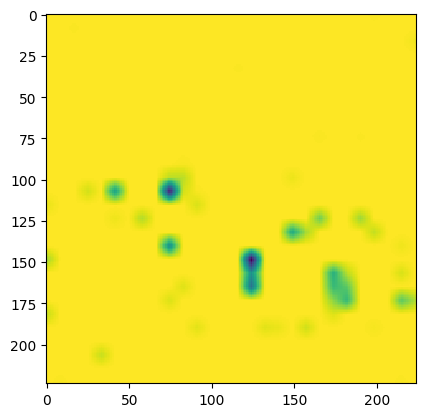

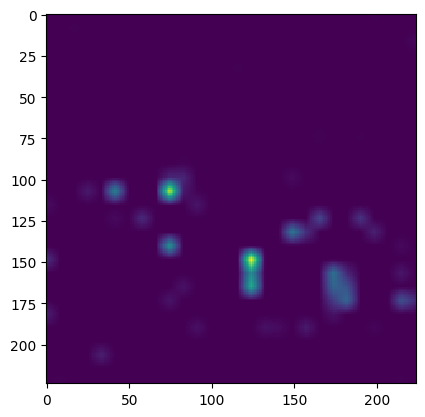

0.05205965

In [36]:
saliency = torch.squeeze(upsampled_mask)
print(saliency.shape)
saliency = saliency.cpu().detach().numpy()
plt.imshow(saliency, interpolation='nearest')
plt.show()
imag = 1-saliency
imag.max()
plt.imshow(imag, interpolation='nearest')
plt.show()
np.max(imag)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


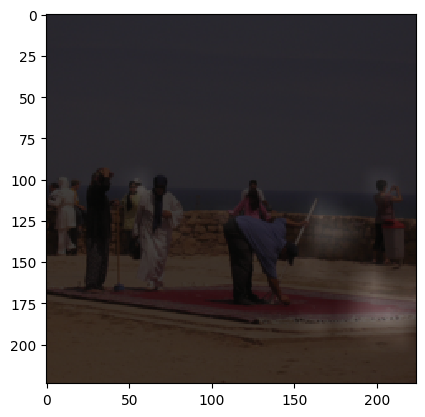

In [217]:
img2 = cv2.merge((imag,imag,imag))
print(type(img2))
print(type(I))
fin = cv2.addWeighted(img2, 0.75, np.float32(I) / 255, 0.25, 0)
plt.imshow(fin, interpolation='nearest')
plt.show()

In [4]:
print(FloatTensor)
print(LongTensor)

<class 'torch.cuda.FloatTensor'>
<class 'torch.cuda.LongTensor'>


In [5]:
print(use_cuda)

True
